# 2022 ACTL3143 Assignment: Mortality Rate Prediction Using Neural Networks
By Kelly Chu (z5255293)

## 1. Introduction

The project will use past population data to predict future mortality rates for Australia. This is a regression type problem with log mortality rates $log(m_x)$ regressed against calendar year $t$, age $x$ and gender to forecast mortality rates. 

We begin by fitting a baseline Lee-Carter model before looking to how predictions can be improved with deep learning models.

## 2. Data Preparation

### 2.1 Load packages

In [55]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

# import minmaxscaler
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.utils import timeseries_dataset_from_array

from scipy.linalg import svd
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf

from tensorflow.keras.utils import timeseries_dataset_from_array

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Input, Concatenate, Flatten, Dense, SimpleRNN, LSTM, GRU
import keras_tuner as kt

from sklearn.metrics import mean_absolute_error, mean_squared_error


In [56]:
def plotPredictions(data, model, datasplit, G):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

    plt.suptitle(f"{country} {G} {model} Prediction on {datasplit} Set")

    
    if datasplit == "Training":
        ax1.set_ylim(0, 0.8)
        ax1.set_xlim(0, 0.8)
        ax2.set_ylim(-0.3, 0.3)
        ax2.set_xlim(0, 0.8)
    elif datasplit == "Validation":
        ax1.set_ylim(0, 0.6)
        ax1.set_xlim(0, 0.6)
        ax2.set_ylim(-0.3, 0.3)
        ax2.set_xlim(0, 0.6)
    else:
        ax1.set_ylim(0, 0.6)
        ax1.set_xlim(0, 0.6)
        ax2.set_ylim(-0.3, 0.3)
        ax2.set_xlim(0, 0.6)


    ax1.scatter(data['mx'], data['pred_mx'])
    ax1.set_ylabel("Predictions")
    ax1.set_xlabel("True values")
    ax1.set_title(f"{datasplit} Set Predictions vs Actual")
    
    xl = ax1.get_xlim()
    yl = ax1.get_ylim()
    shortestSide = min(xl[1], yl[1])
    ax1.plot([0, shortestSide], [0, shortestSide], color="black", linestyle="--")

    sns.regplot(x = data['mx'], y = data['residuals'], data = None, scatter = True, ax=ax2, truncate = False)
    ax2.set_title(f"{datasplit} Set Residuals")

    plt.savefig(f"plots/{country} {G} {model} Prediction on {datasplit} Set")

In [124]:
def plot_train_history(history, title):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.xlabel('epoch')
    plt.ylabel('MSE Loss')
    plt.title(title)
    plt.legend()
    plt.ylim(0, 0.1)
    plt.show()

In [58]:
def nnPredictions(model, x_data, y_data):
    y = y_data.flatten()
    pred = model.predict(x_data).flatten()

    merge = pd.DataFrame({"pred_logmx": pred, "logmx": y})
    merge['pred_mx'] = merge['pred_logmx'].apply(lambda x: np.exp(-x))
    merge['mx'] = merge['logmx'].apply(lambda x: np.exp(-x))
    merge['residuals'] = merge['pred_mx'] - merge['mx']
    merge['loss'] = merge['residuals'] ** 2

    return merge

### 2.2 Load data
The project uses the Australia population data set available on Human Mortality Database (HMD) - labelled as "AUS".
https://www.mortality.org/File/GetDocument/hmd.v6/AUS/STATS/Mx_1x1.txt 

In [59]:
country = 'CHE'
gender = 'Female'

all_mort = pd.read_csv(f"{country}_mort.csv")

if (country == 'CHE'):
    all_mort.drop(columns = ['Country','imputed_flag','logmx'], inplace = True)
    all_mort = all_mort.pivot(index=['Year','Age'], columns='Gender')['mx'].reset_index()
    all_mort.columns.name = None
all_mort.head()

,Year,Age,Female,Male
0,1950,0,0.027293,0.036256
1,1950,1,0.003046,0.003317
2,1950,2,0.001674,0.002161
3,1950,3,0.001234,0.001132
4,1950,4,0.001007,0.001300


In [60]:
country = 'AUS'
gender = 'Male'

all_mort = pd.read_csv('Mx_1x1.txt', skiprows= 2, sep = '\s+')


### 2.3 Data Formatting
- Replace "." with NA
- Encode age bracket "110+" as 110 - will be removed later on as we are investigating ages 0 to 99
- Converting age, mx and gender to int, float and category respectively

In [61]:
# make data wider to longer
all_mort = all_mort.melt(id_vars=['Year','Age'], value_vars =['Female','Male'], var_name = "Gender", value_name='mx')

#change 110+ to 110
all_mort.loc[all_mort['Age'] == '110+', 'Age'] = '110'

#replace . or 0 with NA
all_mort.loc[all_mort['mx'] == '.', 'mx'] = np.nan
all_mort.loc[all_mort['mx'] == 0, 'mx'] = np.nan

#convert type
all_mort['Gender'] = all_mort['Gender'].astype('category')
all_mort['Age'] = all_mort['Age'].astype('int')
all_mort['mx'] = all_mort['mx'].astype('float')
all_mort.dtypes

Year         int64
Age          int32
Gender    category
mx         float64
dtype: object

### 2.4 Data Pre-processing
Pre-processing steps were then applied so that the data is in the proper format for our models. This includes:
- Select calendar years t from 1950
- Select ages to be of values between 0 to 99 years
- Create *logmx* column which is the log of the mx column

In [62]:
#keep rows where year is within range and age is between 0 and 100
all_mort = all_mort[(all_mort['Year'] >= 1950) 
                    & (all_mort['Age'] >= 0) & (all_mort['Age'] < 100)
                    ]

#log mx
all_mort['logmx'] = np.log(all_mort['mx'])

# set index to be equal to the Year
all_mort['t'] = pd.to_datetime(all_mort['Year'], format='%Y')
all_mort.set_index('t', inplace=True)

After cleaning, there are no null values and all features are of expected type.

In [63]:
# check for null values
all_mort.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14000 entries, 1950-01-01 to 2019-01-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Year    14000 non-null  int64   
 1   Age     14000 non-null  int32   
 2   Gender  14000 non-null  category
 3   mx      14000 non-null  float64 
 4   logmx   14000 non-null  float64 
dtypes: category(1), float64(2), int32(1), int64(1)
memory usage: 506.0 KB


## 3. Data Exploration

Select gender to investigate - Female, Male or Total

In [64]:
gender_mort = all_mort[all_mort['Gender'] == gender].drop(columns = ['Gender'])
gender_mort.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7000 entries, 1950-01-01 to 2019-01-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    7000 non-null   int64  
 1   Age     7000 non-null   int32  
 2   mx      7000 non-null   float64
 3   logmx   7000 non-null   float64
dtypes: float64(2), int32(1), int64(1)
memory usage: 246.1 KB


The below heatmap illustrates the relationship between age x and the calendar year t. From the colour scale, red and blue represents low and high mortality rates respectively. 

We can observe the following patterns:
- Age effect: looking for vertical patterns in the heatmap, we can observe that in a given year, mortality rates tends to increase as age increases
- Period effect: looking for horizontal patterns in the heatmap, we can observe that for a given year, mortality rates tends to decrease as calendar year increases

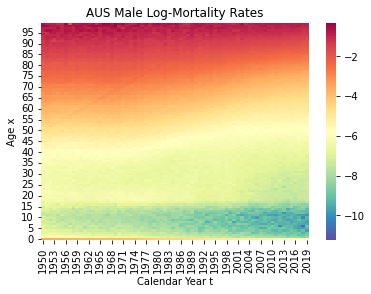

In [65]:
# find min value and max value to set the scale of the label to be consistent between male and female
minvalue = all_mort.logmx.min().min()
maxvalue = all_mort.logmx.max().max()

# pivot data to acceptable form for heatmap
plot_data = pd.pivot_table(gender_mort, values = 'logmx', index = 'Age', columns = 'Year')

# plot heatmap
heatmap = sns.heatmap(data = plot_data,vmin = minvalue, vmax = maxvalue, cmap = "Spectral_r").invert_yaxis()

# add title and labels
plt.title(f"{country} {gender} Log-Mortality Rates")
plt.xlabel('Calendar Year t')
plt.ylabel('Age x')
plt.savefig(f"plots/{country} {gender} Log-Mortality Rates")


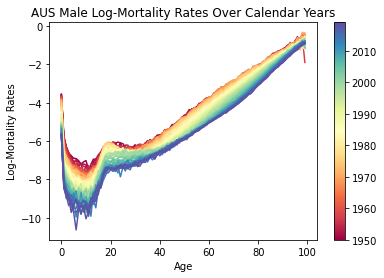

In [66]:
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=plot_data.columns.min(), vmax=plot_data.columns.max())
colormap = cm.Spectral

# plot
for n in plot_data.columns:
    plt.plot(plot_data[n], color=colormap(normalize(n)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(plot_data.columns)
plt.colorbar(scalarmappaple)

# add axis labs
plt.title(f"{country} {gender} Log-Mortality Rates Over Calendar Years")
plt.xlabel('Age')
plt.ylabel('Log-Mortality Rates')

# show the figure
plt.savefig(f"plots/{country} {gender} Log-Mortality Rates Over Calendar Years")
plt.show()


In the below plot, we can observe that improvements in mortality over the past decades is more evident in younger ages - particularly of infants and children whereas those in older ages have experienced relatively less mortality improvements.

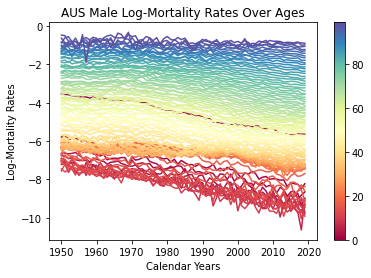

In [67]:
plot_data_t = plot_data.transpose()

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=plot_data_t.columns.min(), vmax=plot_data_t.columns.max())
colormap = cm.Spectral

# plot
for n in plot_data_t.columns:
    plt.plot(plot_data_t[n], color=colormap(normalize(n)))

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(plot_data_t.columns)
plt.colorbar(scalarmappaple)

# add axis labs
plt.title(f"{country} {gender} Log-Mortality Rates Over Ages")
plt.xlabel('Calendar Years')
plt.ylabel('Log-Mortality Rates')

# show the figure
plt.savefig(f"plots/{country} {gender} Log-Mortality Rates Over Ages")
plt.show()


## 4. Split into training, validation and test set

We then split the data into approximately 60% training, 20% validation and 20% test set, split by calendar year. The training set will contain only the observations prioer to the ones from the test set so that no future observations are used in constructing the forecast. This prevents any leaks that may cause a bias in estimation which leads to deviations in prediction error while applying the model to new unseen data.

In [68]:
# find year to split data at 
minYear = gender_mort.Year.min()
maxYear = gender_mort.Year.max()
interval = (maxYear - minYear)/10
traincut = int(minYear + interval * 6)
valcut = int(minYear + interval * 8)
trainall = all_mort[all_mort['Year'] < traincut]
valall = all_mort[(all_mort['Year'] >= traincut) & (all_mort['Year'] < valcut)]
testall = all_mort[all_mort['Year']>= valcut]
minYear, traincut, valcut, maxYear


(1950, 1991, 2005, 2019)

## 5. Baseline Model: Lee-Carter model

In [69]:
# select gender from train
trainfemale = trainall[trainall["Gender"]== "Female"].drop(columns = "Gender")
valfemale = valall[valall["Gender"]== "Female"].drop(columns = "Gender")
testfemale = testall[testall["Gender"]== "Female"].drop(columns = "Gender")

trainmale = trainall[trainall["Gender"]== "Male"].drop(columns = "Gender")
valmale = valall[valall["Gender"]== "Male"].drop(columns = "Gender")
testmale = testall[testall["Gender"]== "Male"].drop(columns = "Gender")

### 5.1 Parameter Estimation on testing Data
The model calculates the logarithm of the central death rate $log(m_{x,t})$ at age $x$ in the calendar year $t$ as:
$$\log(m_{x,t}) = \mathbb{a}_x + b_x k_t + e_{x,t} \tag{$1$} $$
We will calculate the parameters from first principles - methodology can be found in the report appendix

In [70]:
def LCParameters(train):
    #Step 1
    a_x = train.groupby('Age')['logmx'].mean()

    # Step 2
    train = train.assign(
        a_x = train.groupby(by = 'Age')['logmx'].transform('mean'), 
        mx_adj = lambda x: x['logmx'] - x['a_x']
    )
    rates_mat = pd.pivot_table(train, values = 'mx_adj', index = 'Age', columns = 'Year')

    # Step 3
    u, s, vT = svd(rates_mat)

    # Step 4
    b_x = u[:,0] * s[0]
    k_t = vT.transpose()[:,0]

    # Step 5
    c1 = k_t.sum()
    c2 = b_x.sum()
    a_x = a_x + c1 * b_x
    b_x = b_x / c2
    k_t = (k_t - c1) * c2
    
    return a_x, b_x, k_t

In [71]:
a_xF, b_xF, k_tF = LCParameters(trainfemale)
a_xM, b_xM, k_tM = LCParameters(trainmale)

Plots of our parameters reflect much of the observed trends in our exploratory data analysis.

In [72]:
def plotLCParams(a_x, b_x, k_t, train, G):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

    plt.suptitle(f"{country} {G} LC Parameter Estimation")

    ax1.plot(a_x)
    ax1.set_xlabel('Age x')
    ax1.set_title('a_x vs age')

    ax2.plot(b_x)
    ax2.set_xlabel('Age x')
    ax2.set_title('b_x vs x')

    ax3.plot(train.Year.unique(),k_t)
    ax3.set_xlabel('Calendar Year t')
    ax3.set_title('k_t vs t')
    plt.savefig(f"plots/{country} {G} LC Parameter Estimation")

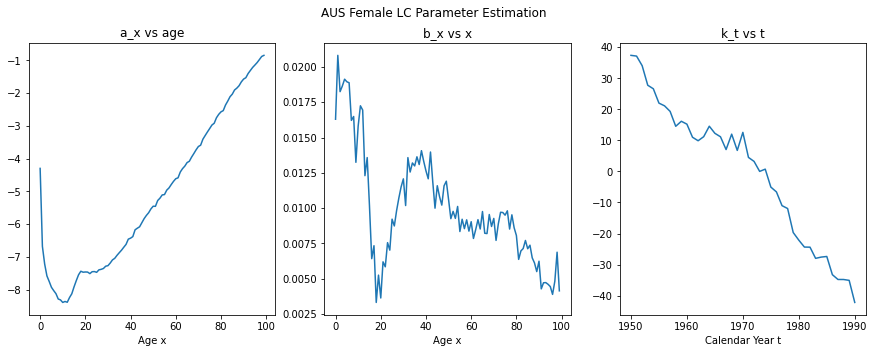

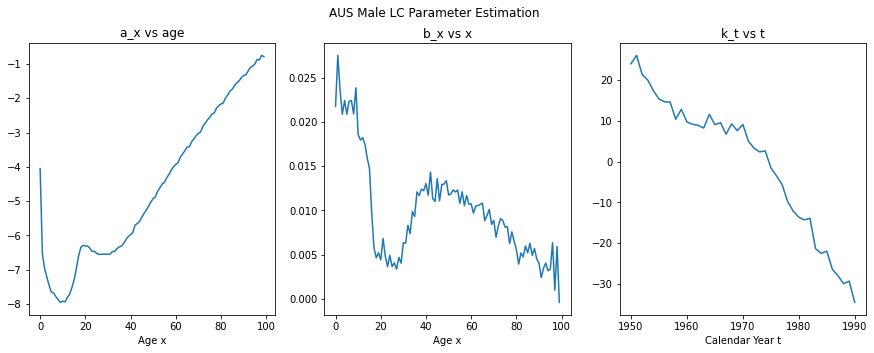

In [73]:
plotLCParams(a_xF, b_xF,k_tF, trainfemale, "Female")
plotLCParams(a_xM, b_xM,k_tM, trainmale, "Male")

### 5.2 Forecast on Validation Data

As $a_x$ and $b_x$ are age-dependent rather than time-dependent, it is assumed they are constant over time. Hence, for our forecast, $k_t$ is the only parameter required to be extrapolated.

This is achieved through projection as a random walk with drift by modelling $k_t$ as an independent ARIMA(0,1,0) process.
$$k_t = k_{t-1} + \gamma + e_t$$
where $e_t ~ N(0,\sigma_\epsilon^2)$ and $\gamma$ is the drift

In [74]:
def LCForecast(train, val, k_t, G):
    # fit ARIMA(0,1,0) to k_t
    model = ARIMA(k_t, order=(0,1,0), trend = "t")
    model_fit = model.fit()

    # forecast k_t and confidence intervals
    forecast = model_fit.get_forecast(steps=len(val.Year.unique()))
    k_t_forecast = forecast.predicted_mean
    k_t_forecast_ci = forecast.conf_int(alpha = 0.05)

    # plot training and forecasted values
    ax4 = plt.subplot(1,1,1)
    ax4.plot(train.Year.unique(), k_t, label='Train')
    ax4.plot(val.Year.unique(), k_t_forecast, label='Forecast (95% CI)')
    ax4.fill_between(val.Year.unique(), k_t_forecast_ci[:,0], k_t_forecast_ci[:,1], color='orange', alpha=.25)
    ax4.set_xlabel('Calendar Year t')
    ax4.set_ylabel('k_t')
    ax4.legend(loc='upper right')
    ax4.set_title(f"{country} {G} Estimated Process k_t")

    plt.savefig(f"plots/{country} {G} Estimated Process k_t")

    return k_t_forecast

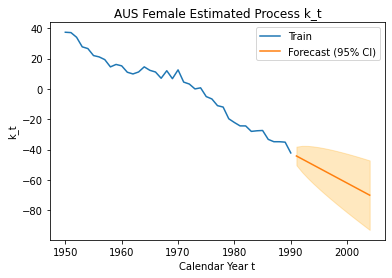

In [75]:
k_t_forecastF = LCForecast(trainfemale, valfemale, k_tF, "Female")


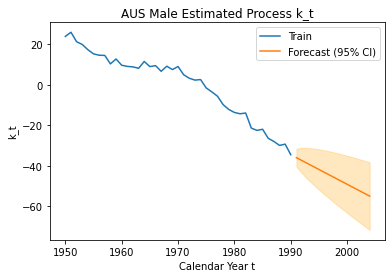

In [76]:
k_t_forecastM = LCForecast(trainmale, valmale, k_tM, "Male")

### 5.3 Fit the model

In [77]:
def fitLC(data, a_x, b_x, k_t): 
    # calculate log(mx) = ax + b_x * k_t
    fitted = np.array([a_x]) + np.dot(np.array([k_t]).T, np.array([b_x]))

    # change to dataframe 
    fitted_df = pd.DataFrame(fitted)

    # add column names
    fitted_df.columns = data.Age.unique()

    # add Year column
    fitted_df['Year'] = data.Year.unique()

    # melt the dataframe
    fitted_dfmelt = fitted_df.melt(id_vars=['Year'], value_name='pred_logmx', var_name='Age')

    # calculate mx = exp(log(mx))
    fitted_dfmelt['pred_mx'] = fitted_dfmelt['pred_logmx'].apply(lambda x: np.exp(x))

    # merge train and fitted data
    merge = pd.merge(data, fitted_dfmelt, on=['Year', 'Age'])

    # add residuals column
    merge['residuals'] = merge['pred_mx'] - merge['mx']

    return merge


In [78]:
LC_trainF = fitLC(trainfemale, a_xF, b_xF, k_tF)
LC_valF = fitLC(valfemale, a_xF, b_xF, k_t_forecastF)
LC_trainM = fitLC(trainmale, a_xM, b_xM, k_tM)
LC_valM = fitLC(valmale, a_xM, b_xM, k_t_forecastM)

### 5.3 Model Assessment

Plots of prediction performance reveal that our Lee Carter model performs quite well with most of the predictions lying on a 45 degree line in a plot against the actual values. Residuals also to be close to zero, however it should be noted that residuals tend to be larger when predicting higher mortality rates.

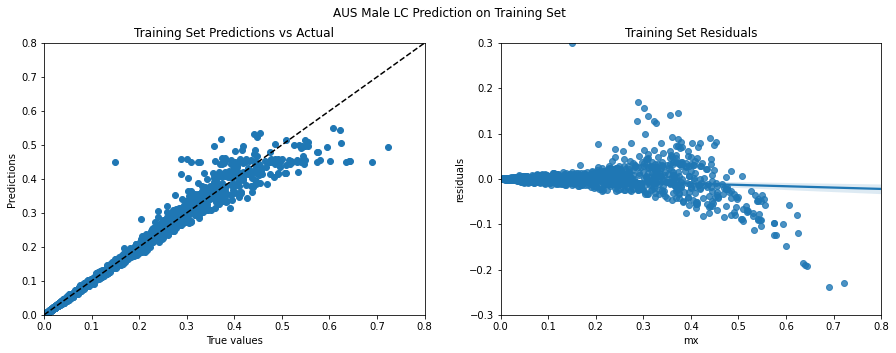

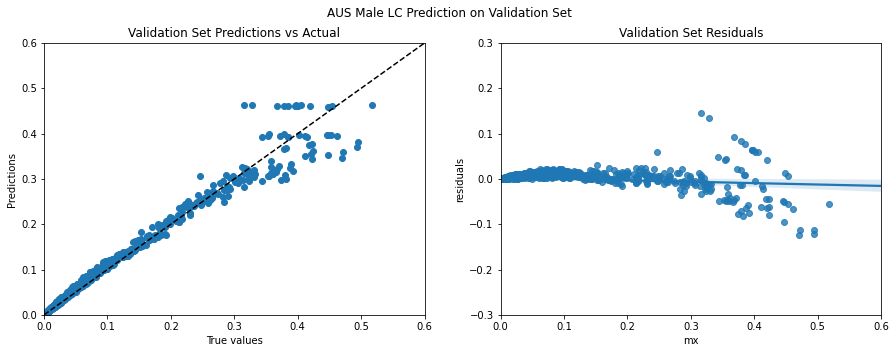

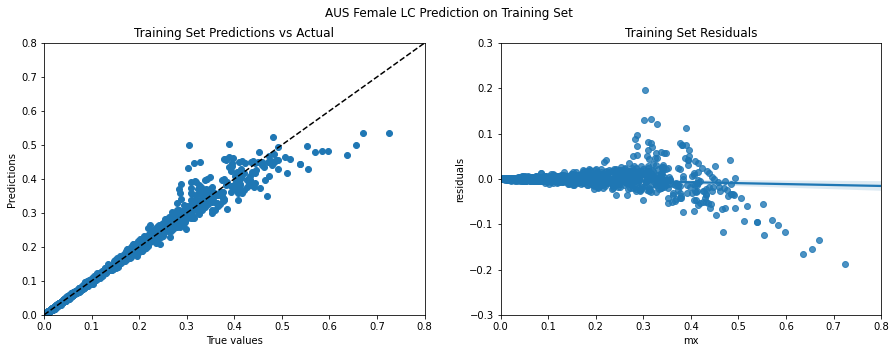

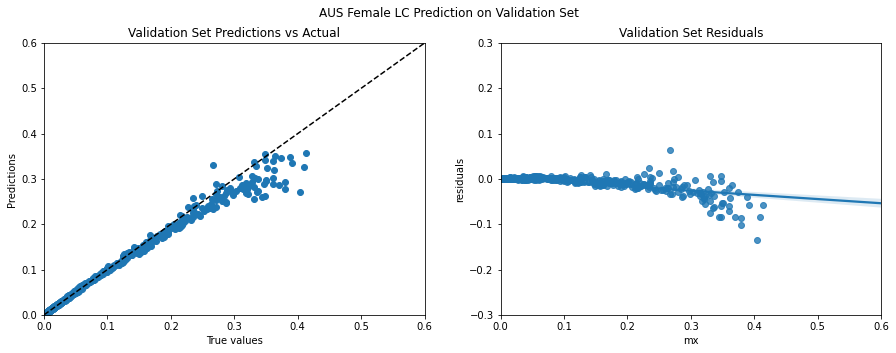

In [79]:
plotPredictions(LC_trainM, 'LC', 'Training', "Male")
plotPredictions(LC_valM, 'LC', 'Validation', "Male")
plotPredictions(LC_trainF, 'LC', 'Training', "Female")
plotPredictions(LC_valF, 'LC', 'Validation', "Female")

Calculation of MSE

The mean squared error was then calculated between the Lee Carter model's estimates of $m_x$ and the raw data's $m_x$. This serves as the baseline for our neural networks to beat.

In [80]:
mseLCTrainF = mean_squared_error(LC_trainF['mx'], LC_trainF['pred_mx'])
mseLCValF = mean_squared_error(LC_valF['mx'], LC_valF['pred_mx'])

mseLCTrainM = mean_squared_error(LC_trainM['mx'], LC_trainM['pred_mx'])
mseLCValM = mean_squared_error(LC_valM['mx'], LC_valM['pred_mx'])

mseTrain = {"Lee Carter": [mseLCTrainF, mseLCTrainM, (mseLCTrainF + mseLCTrainM)/2]}
mseVal = {"Lee Carter": [mseLCValF, mseLCValM, (mseLCValF + mseLCValM)/2]}


## 6. Deep Learning Model 1: GRU

### Helper functions

In [81]:
#Source: https://mobiarch.wordpress.com/2020/11/13/preparing-time-series-data-for-rnn-in-tensorflow/
def timeseries_dataset_one_step(features, labels, input_sequence_length): 
    return tf.keras.preprocessing.timeseries_dataset_from_array(features[:-1], \
            np.roll(labels, -input_sequence_length, axis=0)[:-1], \
            input_sequence_length)

In [82]:
def GRUDataProcessing(data, T0):
  xmat = np.zeros((1, T0, 1))
  ymat = np.zeros((1, 1))
  for age in range(data.Age.max()):
    inputdata = data[data['Age'] == age].drop(columns = ["mx", "Age", "Year"])

    # Predict the next year ahead.
    ahead = 1

    # The index of the first target.
    delay = (T0+ahead-1)

    DS = \
      timeseries_dataset_one_step(
        inputdata,
        inputdata,
        T0
        )

    x_age = np.concatenate(list(DS.map(lambda x, y: x)))
    y_age = np.concatenate(list(DS.map(lambda x, y: y)))

    xmat= np.append(xmat, x_age, axis = 0)
    ymat = np.append(ymat, y_age, axis= 0)
  xmat = xmat[1:]
  ymat = ymat[1:]
  return xmat, ymat

### 6.1 Prepare the data

In [83]:
# set parameters
T0 = 10 # lookback period

# data processing
x_trainF, y_trainF = GRUDataProcessing(trainfemale, T0)
x_trainM, y_trainM = GRUDataProcessing(trainmale, T0)
x_valF, y_valF = GRUDataProcessing(valfemale, T0)
x_valM, y_valM = GRUDataProcessing(valmale, T0)
x_testF, y_testF = GRUDataProcessing(testfemale, T0)
x_testM, y_testM = GRUDataProcessing(testmale, T0)


In [84]:
def combinedata(xdataF, ydataF, xdataM, ydataM):
    numRows = xdataF.shape[0]
    genderIndicator = np.tile([0,1], numRows) #note, 0 is Female

    yDATA = np.zeros((numRows * 2, 1))
    xDATA = np.zeros((numRows * 2, T0, 1))

    for l in range(numRows):
        xDATA[l*2] = xdataF[l]
        xDATA[l*2 + 1] = xdataM[l]
        yDATA[l*2] = ydataF[l]
        yDATA[l*2 + 1] = ydataM[l]
    return xDATA, yDATA, genderIndicator

x_train, y_train, genderIndicator_train = combinedata(x_trainF, y_trainF, x_trainM, y_trainM)
x_val, y_val, genderIndicator_val = combinedata(x_valF, y_valF, x_valM, y_valM)
x_test, y_test, genderIndicator_test = combinedata(x_testF, y_testF, x_testM, y_testM)


In [85]:
# scale the data
x_min = x_train.min(axis = 0).min(axis = 0).min(axis = 0)
x_max = x_train.max(axis = 0).max(axis = 0).max(axis = 0)
f = lambda x: 2 * (x - x_min) / (x_min - x_max) - 1
x_train= f(x_train)
x_val = f(x_val)
x_test = f(x_test)

x_trainF= f(x_trainF)
x_valF = f(x_valF)
x_testF = f(x_testF)

x_trainM= f(x_trainM)
x_valM = f(x_valM)
x_testM = f(x_testM)

y_train = -y_train
y_val = -y_val
y_test = -y_test

y_trainF = -y_trainF
y_valF = -y_valF
y_testF = -y_testF

y_trainM = -y_trainM
y_valM = -y_valM
y_testM = -y_testM

# append gender
x_train = [x_train, genderIndicator_train]
x_val = [x_val, genderIndicator_val]
x_test = [x_test, genderIndicator_test]

x_trainF = [x_trainF, np.tile(0, x_trainF.shape[0])]
x_valF = [x_valF, np.tile(0, x_valF.shape[0])]
x_testF = [x_testF, np.tile(0, x_testF.shape[0])]

x_trainM = [x_trainM, np.tile(0, x_trainM.shape[0])]
x_valM = [x_valM, np.tile(0, x_valM.shape[0])]
x_testM = [x_testM, np.tile(0, x_testM.shape[0])]

### 6.2 Define the model

In [138]:
def model_builder(hp):
    layers = hp.Int('layers', 1,3)
    activation = hp.Choice('activation', ['relu', 'tanh'])
    dropout = hp.Float('dropout', 0.0, 0.5, step = 0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')

    inp = Input(shape=(T0, 1), name = "input")
    gender = Input(shape = (1), name = "gender")
    
    x = inp
    for i in range(layers):
        x = GRU(units = hp.Int(f'neurons_{i}', min_value = 5, max_value = 20, step = 5),dropout = dropout, activation = activation, return_sequences = True, name = f"GRU{i+1}")(x)
    x = GRU(units = hp.Int(f'final_neurons', min_value = 5, max_value = 20, step = 5), dropout = dropout, activation = activation, name = f"FinalGRU")(x)
    concat = Concatenate(name = "combined")([x, gender])
    output = Dense(1, name = "Output", activation = 'exponential')(concat)
    modelGRU = Model(inputs = [inp, gender], outputs = [output])
    modelGRU.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate = learning_rate))

    return modelGRU

### 6.3 Fit the model

In [139]:
tuner = kt.BayesianOptimization(
    model_builder, 
    objective = 'val_loss',
    max_trials = 50,
    overwrite = True,
    directory = "BOGRU10")

tuner.search_space_summary()

TypeError: Int() got an unexpected keyword argument 'dropout'

In [118]:
es = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

tuner.search(
    x_train, y_train, 
    epochs = 100,
    validation_data = (x_val, y_val), 
    callbacks = [es], 
    verbose = 1)

Trial 50 Complete [00h 00m 26s]
val_loss: 0.019910428673028946

Best val_loss So Far: 0.017848007380962372
Total elapsed time: 00h 27m 27s
INFO:tensorflow:Oracle triggered exit


In [135]:
tuner.results_summary()

Results summary
Results in BOGRU10\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 2
activation: tanh
outputactivation: exponential
neurons_0: 20
final_neurons: 5
neurons_1: 5
neurons_2: 5
Score: 0.017848007380962372
Trial summary
Hyperparameters:
layers: 1
activation: tanh
outputactivation: exponential
neurons_0: 20
final_neurons: 5
neurons_1: 5
neurons_2: 5
Score: 0.018318502232432365
Trial summary
Hyperparameters:
layers: 1
activation: tanh
outputactivation: exponential
neurons_0: 15
final_neurons: 5
neurons_1: 5
neurons_2: 5
Score: 0.018318863585591316
Trial summary
Hyperparameters:
layers: 1
activation: tanh
outputactivation: exponential
neurons_0: 15
final_neurons: 5
neurons_1: 5
neurons_2: 5
Score: 0.018450913950800896
Trial summary
Hyperparameters:
layers: 1
activation: tanh
outputactivation: exponential
neurons_0: 15
final_neurons: 5
neurons_1: 5
neurons_2: 5
Score: 0.018474197015166283
Trial summary
Hyperparameters:
layers: 1
activation: tanh
ou

In [119]:
best_params = tuner.get_best_hyperparameters()
best_params[0].values

{'layers': 2,
 'activation': 'tanh',
 'outputactivation': 'exponential',
 'neurons_0': 20,
 'final_neurons': 5,
 'neurons_1': 5,
 'neurons_2': 5}

In [120]:
bestGRUModel = tuner.get_best_models()[0]
bestGRUModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 10, 1)]      0           []                               
                                                                                                  
 GRU1 (GRU)                     (None, 10, 20)       1380        ['input[0][0]']                  
                                                                                                  
 GRU2 (GRU)                     (None, 10, 5)        405         ['GRU1[0][0]']                   
                                                                                                  
 FinalGRU (GRU)                 (None, 5)            180         ['GRU2[0][0]']                   
                                                                                              

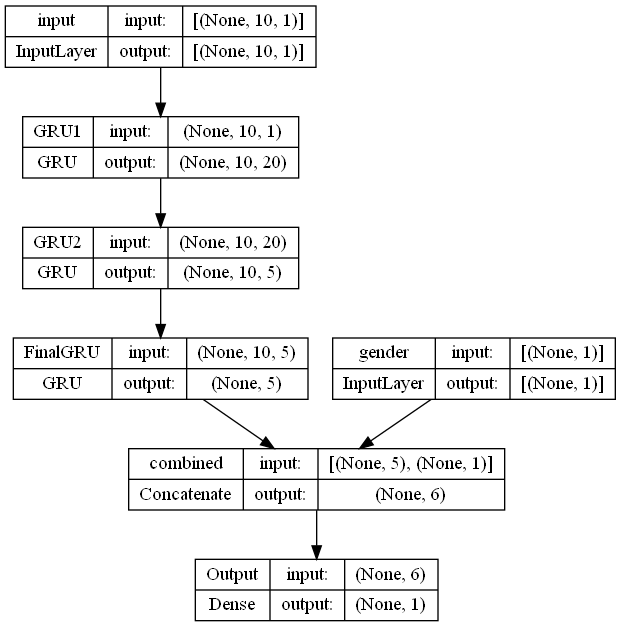

In [121]:
plot_model(bestGRUModel, show_shapes=True)

### 6.4 Model Assessment

In [122]:
hist = bestGRUModel.fit(x = x_train, y = y_train, epochs = 100, validation_data = (x_val, y_val), callbacks = [es])

Epoch 1/100
192/192 [==============================] - 5s 13ms/step - loss: 0.0159 - val_loss: 0.0195
Epoch 2/100
192/192 [==============================] - 2s 9ms/step - loss: 0.0166 - val_loss: 0.0289
Epoch 3/100
192/192 [==============================] - 2s 9ms/step - loss: 0.0161 - val_loss: 0.0186
Epoch 4/100
192/192 [==============================] - 2s 9ms/step - loss: 0.0176 - val_loss: 0.0208
Epoch 5/100
192/192 [==============================] - 2s 9ms/step - loss: 0.0168 - val_loss: 0.0185
Epoch 6/100
192/192 [==============================] - 2s 9ms/step - loss: 0.0155 - val_loss: 0.0193
Epoch 7/100
192/192 [==============================] - 2s 9ms/step - loss: 0.0159 - val_loss: 0.0291
Epoch 8/100
192/192 [==============================] - 2s 9ms/step - loss: 0.0164 - val_loss: 0.0251
Epoch 9/100
192/192 [==============================] - 2s 9ms/step - loss: 0.0150 - val_loss: 0.0182
Epoch 10/100
192/192 [==============================] - 2s 9ms/step - loss: 0.0156 - val_l

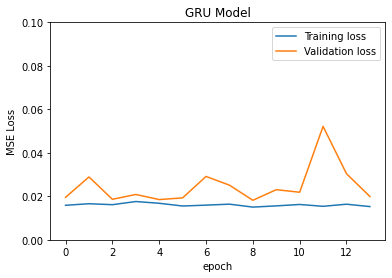

In [132]:
plot_train_history(hist, "GRU Model")

In [126]:
GRU_trainF = nnPredictions(bestGRUModel, x_trainF, y_trainF)
GRU_valF = nnPredictions(bestGRUModel, x_valF, y_valF)
GRU_trainM = nnPredictions(bestGRUModel, x_trainM, y_trainM)
GRU_valM = nnPredictions(bestGRUModel, x_valM, y_valM)

13/13 [==============================] - 0s 3ms/step


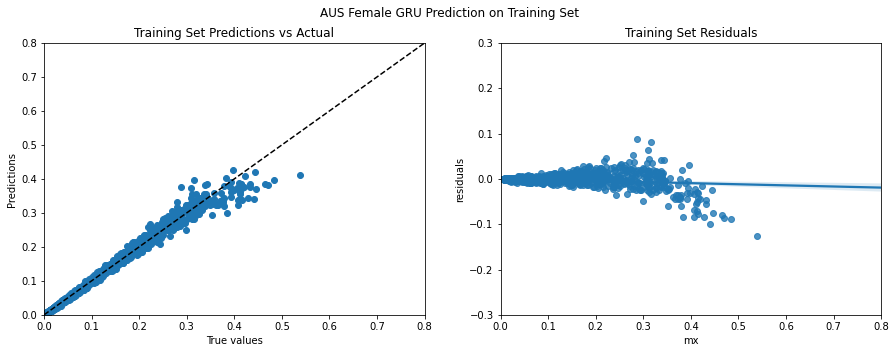

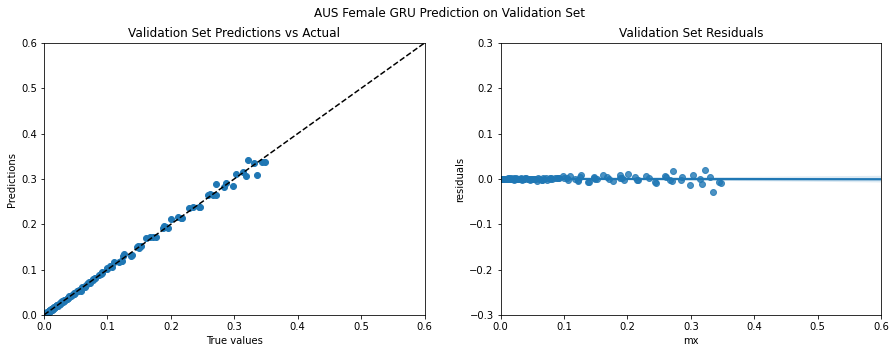

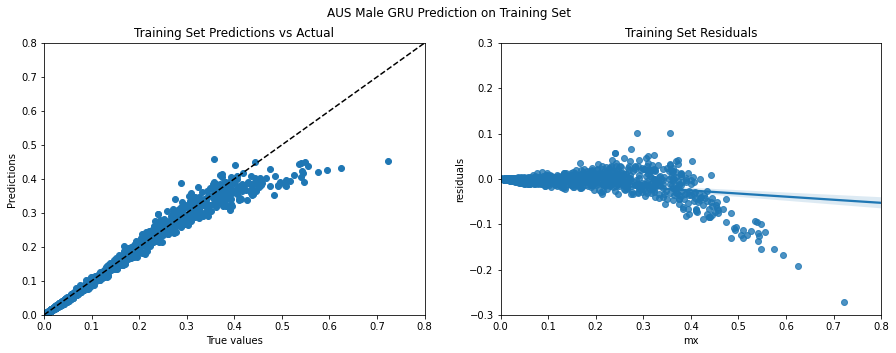

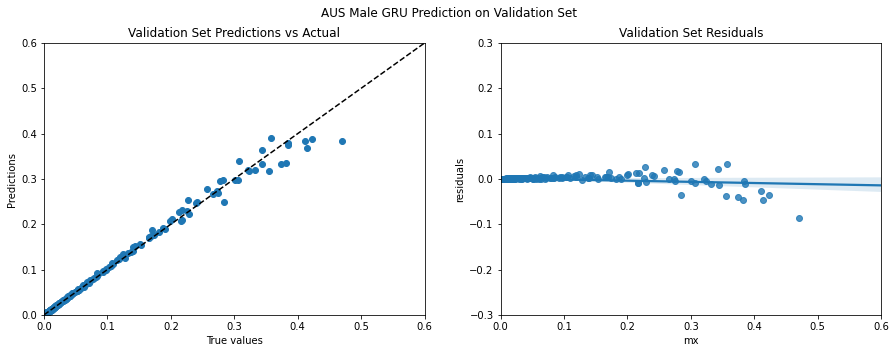

In [133]:
plotPredictions(GRU_trainF, 'GRU','Training', 'Female')
plotPredictions(GRU_valF, 'GRU', 'Validation', 'Female')
plotPredictions(GRU_trainM, 'GRU','Training', 'Male')
plotPredictions(GRU_valM, 'GRU', 'Validation', 'Male')

In [134]:
mseGRUTrainF = mean_squared_error(GRU_trainF['mx'], GRU_trainF['pred_mx'])
mseGRUValF = mean_squared_error(GRU_valF['mx'], GRU_valF['pred_mx'])

mseGRUTrainM = mean_squared_error(GRU_trainM['mx'], GRU_trainM['pred_mx'])
mseGRUValM = mean_squared_error(GRU_valM['mx'], GRU_valM['pred_mx'])

mseTrain["GRU"] = [mseGRUTrainF, mseGRUTrainM, (mseGRUTrainF + mseGRUTrainM)/2]
mseVal["GRU"] =  [mseGRUValF, mseGRUValM, (mseGRUValF + mseGRUValM)/2]

## 7. Deep Learning Model 2:

### 7.1 Data Processing

## 8. Evaluation of Final Chosen Model on Test Data

### 8.1 Selection of Final Model

In [129]:
trainResults = pd.DataFrame(mseTrain).transpose()
trainResults.columns = ["Female", "Male", "Both"]
valResults = pd.DataFrame(mseVal).transpose()
valResults.columns = ["Female", "Male", "Both"]


In [130]:
trainResults

,Female,Male,Both
Lee Carter,0.000144,0.000287,0.000215
GRU,0.000080,0.000249,0.000165


In [131]:
valResults

,Female,Male,Both
Lee Carter,0.000116,0.000212,0.000164
GRU,0.000008,0.000064,0.000036


### 8.2 Model Evaluation of Selected Model on Test Data